# Full-Text Search vs Vector Search in DuckDB

This is a companion notebook for [a video showing how to do FTS vs Vector Search in DuckDB](https://www.youtube.com/watch?v=U6k7HnQiWzc).

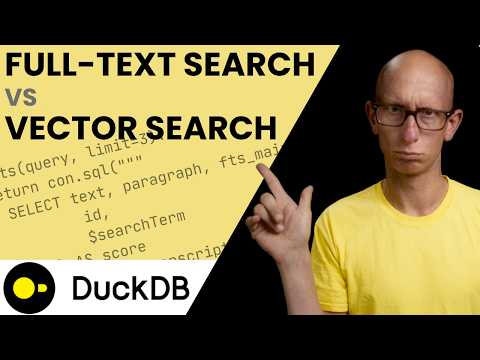

In [29]:
from IPython.display import YouTubeVideo
YouTubeVideo('U6k7HnQiWzc', width=560, height=315)

In [1]:
file = "data/ep68.txt"
with open(file, 'r') as reader:
    texts = reader.read()

In [2]:
from rich.console import Console
c = Console()

with c.pager(styles=True):
  c.print(texts)

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
  chunk_size=300,
  chunk_overlap=100,
  length_function=len,
  is_separator_regex=False,
)

In [6]:
documents = text_splitter.create_documents([texts])
print(len(documents))

308


In [7]:
with c.pager(styles=True):
  c.print(documents[0])

Document(
    page_content="so chris last week of course the big news was claude sonnet 3.5 we said on that episode we would 
daily drive sonnet 3.5 for the entire week which i did and i know you did as well so what do you think now you've 
had one week of experience with claude sonnet well it's been a pleasure and i think i'm"
)


In [8]:
import llama_cpp

In [9]:
llm = llama_cpp.Llama(
  model_path="./models/mxbai-embed-large-v1-f16.gguf", 
  embedding=True, 
  verbose=False
)

In [10]:
%%time
embeddings = llm.create_embedding([item.page_content for item in documents])

CPU times: user 1min 57s, sys: 7.21 s, total: 2min 4s
Wall time: 24.7 s


In [11]:
documents_embeddings = [ 
  (document, embeddings['embedding'])  
  for document, embeddings in zip(documents, embeddings['data'])
]

In [12]:
import duckdb
import uuid

In [13]:
con = duckdb.connect("podcasts.duckdb")
con.sql("""CREATE TABLE podcast_transcript (
id STRING,
episode INTEGER,
paragraph INTEGER,
text STRING,
embeddings FLOAT[1024]
)""")

In [14]:
for index, (document, embeddings) in enumerate(documents_embeddings):
  con.execute(
    "INSERT INTO podcast_transcript VALUES (?, ?, ?, ?, ?)", 
    [str(uuid.uuid4()), 68, index, document.page_content, embeddings]
  )

In [15]:
con.sql("INSTALL fts")

In [16]:
con.sql("LOAD fts")

In [17]:
con.sql("""
PRAGMA create_fts_index(
    'podcast_transcript', 'id', 'text', overwrite=1
);
""")

In [18]:
def fts(query, limit=3):
  return con.sql("""
    SELECT text, paragraph, fts_main_podcast_transcript.match_bm25(
            id,
            $searchTerm
        ) AS score
    FROM podcast_transcript
    WHERE score IS NOT NULL
    ORDER BY score DESC
    LIMIT $limit
    """, params={"searchTerm": query, "limit": limit})

In [19]:
def vector_search(query, limit=3):
  search_vector = llm.create_embedding([query])['data'][0]['embedding']
  return con.sql("""
    SELECT text, paragraph, 
           array_cosine_similarity(
             embeddings, $searchVector::FLOAT[1024]
           ) AS score
    FROM podcast_transcript
    ORDER BY score DESC
    LIMIT $limit
    """, params={"searchVector": search_vector, "limit": limit})

In [20]:
query = "What are Apple doing around AI?"
display(fts(query))
display(vector_search(query))


┌─────────────────────────────────────────────────────────────────────────────────────┬───────────┬────────────────────┐
│                                        text                                         │ paragraph │       score        │
│                                       varchar                                       │   int32   │       double       │
├─────────────────────────────────────────────────────────────────────────────────────┼───────────┼────────────────────┤
│ integrated soon to be integrated with Apple devices. You'll probably just, you kn…  │         9 │  2.922646170812853 │
│ commented last week that people just don't know that Anthropic exists and they ju…  │         8 │  2.075428333815724 │
│ is 100 being written by ai like there's just no doubt in my mind this is from ai …  │       148 │ 1.1605148483879124 │
└─────────────────────────────────────────────────────────────────────────────────────┴───────────┴────────────────────┘


┌─────────────────────────────────────────────────────────────────────────────────────────────┬───────────┬────────────┐
│                                            text                                             │ paragraph │   score    │
│                                           varchar                                           │   int32   │   float    │
├─────────────────────────────────────────────────────────────────────────────────────────────┼───────────┼────────────┤
│ integrated soon to be integrated with Apple devices. You'll probably just, you know, that…  │         9 │  0.7262134 │
│ work with AI day to day. And I think when it comes to businesses using them at the core o…  │        10 │ 0.68550885 │
│ people are working with AI day to day, where you have a document you're trying to produce…  │        18 │  0.6507178 │
└─────────────────────────────────────────────────────────────────────────────────────────────┴───────────┴────────────┘

In [21]:
from rich.table import Table
import random

In [22]:
def format_results(query, fts_res, vector_res):
  results = zip(fts_res.fetchall(), vector_res.fetchall())
  table = Table(title=query)
  table.add_column("FTS")
  table.add_column("Vector")
  colors = random.sample([15, 11, 14, 13, 9, 200], len(fts_res))  
  for index, (a, b) in enumerate(results):
    table.add_row(a[0], b[0], style=f"color({colors[index]})")
  return table

In [23]:
query = """
Which AI model did they refer to as having a 'death blow' impact?
"""
with c.pager(styles=True):
  c.print(format_results(query, fts(query), vector_search(query)))

                                                                                                                   
                         Which AI model did they refer to as having a 'death blow' impact?                         
                                                                                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ FTS                                                    ┃ Vector                                                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ is so far superior to gpt 4.0 that i i don't know like │ admit it like even if they press, like you'd have to   │
│ i'm almost scared for open ai like i'm like they       │ get me in like a freaking cross-examination or         │
│ better have something because this this is like a      │ something to 

In [24]:
query = """
Which company is making their AI inaccessible?
"""
with c.pager(styles=True):
  c.print(format_results(query, fts(query), vector_search(query)))

                                                                                                                   
                                  Which company is making their AI inaccessible?                                   
                                                                                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ FTS                                                    ┃ Vector                                                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ into hosting events, into forcing companies into using │ Google Cloud. We use it for our company right but if i │
│ it, like making them an offer they can't refuse to use │ try to access google's ai stuff through our company    │
│ their models over others? There just doesn't seem to   │ account i'm b

In [25]:
query = """
Which company is making their AI inaccessible?
"""
with c.pager(styles=True):
  c.print(format_results(query, fts(query), vector_search(query)))

                                                                                                                   
                                  Which company is making their AI inaccessible?                                   
                                                                                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ FTS                                                    ┃ Vector                                                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ into hosting events, into forcing companies into using │ Google Cloud. We use it for our company right but if i │
│ it, like making them an offer they can't refuse to use │ try to access google's ai stuff through our company    │
│ their models over others? There just doesn't seem to   │ account i'm b